## Main Triode Class

In [22]:
import numpy as np
import pickle
from scipy.optimize import curve_fit, least_squares, root_scalar
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.interpolate import griddata, RBFInterpolator, LinearNDInterpolator
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.fft import rfft, rfftfreq
from tqdm import tqdm
import warnings
from math import floor, log10
warnings.filterwarnings("ignore")

class InvalidOpPoint(Exception):
    """Custom exception for invalid operational point."""
    def __init__(self, message="Invalid op point selected", value=None):
        super().__init__(message)
        self.value = value

# Define Tube class
class Tube:
    def __init__(self, Vp_data, Ia_data, Vg_data):
        self.Vp_data = Vp_data
        self.Ia_data = Ia_data
        self.Vg_data = Vg_data
        self.three_D_manifold()
        
    def three_D_manifold(self):
        # Generate interpolation grid
        self.Vp_grid, self.Vg_grid = np.meshgrid(
            np.linspace(min(self.Vp_data), max(self.Vp_data), 200),
            np.linspace(min(self.Vg_data), max(self.Vg_data), 200)
        )
        grid_points = np.column_stack((self.Vp_grid.ravel(), self.Vg_grid.ravel()))

        # Fit RBF interpolator
        rbf_interp = RBFInterpolator(
            np.column_stack((self.Vp_data, self.Vg_data)),
            self.Ia_data,
            kernel = "quintic",
            smoothing = 200,
        )
        Ia_rbf = rbf_interp(grid_points)

        # Mask extrapolated values using Delaunay triangulation
        hull = Delaunay(np.column_stack((self.Vp_data, self.Vg_data)))
        mask = hull.find_simplex(grid_points) >=  0
        Ia_rbf[~mask] = np.nan  # set extrapolated values to NaN

        # Reshape to grid
        self.Ia_grid = Ia_rbf.reshape(self.Vp_grid.shape)
        
    def plot_three_D_manifold(self):
        # Step 4: Plot the surface
        fig = plt.figure(figsize = (10, 10))
        ax = fig.add_subplot(111, projection = '3d')
        ax.plot_surface(self.Vp_grid, self.Vg_grid, self.Ia_grid, cmap = 'viridis', linewidth = 0, antialiased = True)
        
        ax.set_xlabel('Plate Voltage Vp (V)')
        ax.set_ylabel('Grid Voltage Vg (V)')
        ax.set_zlabel('Plate Current Ia (mA)')
        ax.set_title('Interpolated Plate Curve Surface')
        plt.tight_layout()
        plt.show()

    def query_point(self, Vp = None, Vg = None, Ia = None):
        if not [Vp is None, Vg is None, Ia is None].count(True) == 1:
            print("Error: please supply exactly two of three coordinates")
            return
            
        if Vp is None:
            known_points_VgIa = np.column_stack((self.Vg_data, self.Ia_data))
            return griddata(known_points_VgIa, self.Vp_data, np.column_stack([Vg, Ia]), method='linear')
            
        elif Vg is None:
            known_points_VpIa = np.column_stack((self.Vp_data, self.Ia_data))
            return griddata(known_points_VpIa, self.Vg_data, np.column_stack([Vp, Ia]), method='linear')
            
        elif Ia is None:
            known_points_VpVg = np.column_stack((self.Vp_data, self.Vg_data))
            return griddata(known_points_VpVg, self.Ia_data, np.column_stack([Vp, Vg]), method='linear')

class Triode(Tube): # Triode inherits from Tube
    def __init__(self, Vp_data, Ia_data, Vg_data, max_diss, mu, gm, plate_resist):
        super().__init__(Vp_data, Ia_data, Vg_data) # Call parent's constructor
        self.max_diss = max_diss
        self.mu = mu
        self.gm = gm
        self.plate_resist = plate_resist

class Tetrode(Tube): # Tetrode inherits from Tube
    def __init__(self, Vp_data, Ia_data, Vg_data, max_diss, mu, gm, plate_resist):
        super().__init__(Vp_data, Ia_data, Vg_data) # Call parent's constructor
        self.max_diss = max_diss
        self.mu = mu
        self.gm = gm
        self.plate_resist = plate_resist

class Pentode(Tube): # Pentode inherits from Tube
    def __init__(self, Vp_data, Ia_data, Vg_data, max_diss, mu, gm, plate_resist):
        super().__init__(Vp_data, Ia_data, Vg_data) # Call parent's constructor
        self.max_diss = max_diss
        self.mu = mu
        self.gm = gm
        self.plate_resist = plate_resist

class Circuit:
    def __init__(self, triode, output_impede, B_plus, pk_pk, debug = False):
        self.triode = triode
        self.output_impede = output_impede if output_impede else 1e6  # Infinite CCS
        self.B_plus = B_plus
        self.pk_pk = pk_pk
        self.debug = debug

class Basic_Circuit(Circuit):
    def __init__(self, triode, B_plus, anode_resist, cathode_resist, plate_current, pk_pk, output_impede = None, debug = False):
        super().__init__(triode, output_impede, B_plus, pk_pk, debug = False) # Call parent's constructor
        self.anode_resist = anode_resist # defines load line
        self.cathode_resist = cathode_resist # defines op point
        self.plate_current = plate_current

        # Define load line parameters
        self.max_current = (self.B_plus / self.anode_resist) * 1000 # b
        self.load_m = -self.max_current / self.B_plus # m
        self.Vg = -(self.plate_current / 1000) * self.cathode_resist

    def load_line_function(self, Vp_query):
        Ia = self.load_m * Vp_query + self.max_current # y = mx + b
        return Ia
        
    def plot_load_line(self):
        # Plotting
        plt.figure(figsize = (10, 6))

        Vp_query = np.linspace(self.triode.Vp_grid.min(), self.triode.Vp_grid.max(), 500)

        # Traced from data sheet
        for Vg_target in np.unique(self.triode.Vg_data):            
            # Re-interpolate query points at each fixed grid voltage
            Ia_interp = self.triode.query_point(Vp = Vp_query, Vg = np.full_like(Vp_query, Vg_target))
            
            # Plot the result
            plt.plot(Vp_query, Ia_interp, label = f"Vg = {Vg_target}V")
                    
        # Plot load line
        interp_Ia_array = self.load_line_function(Vp_query)
        plt.plot(Vp_query, interp_Ia_array, label = f"Load Line (R_out = {int(self.anode_resist)} Ω)", color = 'red', linestyle = '--')
        
        # Plot operating point
        pseudo_Vp_op = (self.plate_current - self.max_current) / self.load_m # y = mx + b
        plt.plot(pseudo_Vp_op, self.plate_current, color = 'red', marker = 'o', linestyle = "none", label = "Op Point (V = %.2f)" % self.triode.query_point(Vp = pseudo_Vp_op, Ia = self.plate_current))
        
        # Plot maximum dissipation
        plt.plot(Vp_query, [self.triode.max_diss * 1000 / i for i in Vp_query], label = "Max dissipation", color = 'black', linestyle = '--')

        # Plot voltage swing path
        interp_Vg_array = self.triode.query_point(Vp = Vp_query, Ia = interp_Ia_array)
        query_indices = [i for i, x in enumerate(interp_Vg_array) if self.Vg - self.pk_pk / 2 <= x <= self.Vg + self.pk_pk / 2]

        plt.plot(Vp_query[query_indices], interp_Ia_array[query_indices], "r-", label = "Voltage Swing Path")
        plt.plot(Vp_query[query_indices][0], interp_Ia_array[query_indices][0], 'go', label = "Swing Start (V = %.2f)" % Vp_query[query_indices][0])
        plt.plot(Vp_query[query_indices][-1], interp_Ia_array[query_indices][-1], 'mo', label = "Swing End (V = %.2f)" % Vp_query[query_indices][-1])
        print("Gain = %f" % ((Vp_query[query_indices][-1] - Vp_query[query_indices][0]) / self.pk_pk))
        
        plt.xlabel('Plate Voltage Vp (V)')
        plt.ylabel('Plate Current Ia (mA)')
        plt.xlim([0, max(self.triode.Vp_data) * 1.1])
        plt.ylim([0, max(self.triode.Ia_data) * 1.1])
        plt.title('Triode Plate Curves')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Animate
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111, projection = '3d')
        ax.plot_surface(self.triode.Vp_grid, self.triode.Vg_grid, self.triode.Ia_grid, cmap = 'viridis', alpha = 0.6)
        ax.set_xlabel("Plate Voltage Vp (V)")
        ax.set_ylabel("Grid Voltage Vg (V)")
        ax.set_zlabel("Plate Current Ia (mA)")
        ax.set_title("Plate Curves with Animated Load Line Swing (Root Scalar, Vg fixed)")
        #ax.view_init(elev = 30, azim = 135)
        
        line, = ax.plot([], [], [], 'r-', linewidth = 3)
        point, = ax.plot([], [], [], 'ro')
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
            return line, point
        
        def animate(i):
            line.set_data(Vp_query[query_indices][:i+1], interp_Vg_array[query_indices][:i+1])
            line.set_3d_properties(interp_Ia_array[query_indices][:i+1])
            point.set_data([Vp_query[query_indices][i]], [interp_Vg_array[query_indices][i]])
            point.set_3d_properties([interp_Ia_array[query_indices][i]])
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func = init,
                                      frames = len(interp_Vg_array[query_indices]), interval = 50, blit = True)
        
        ani.save("triode_voltage_swing.gif", writer = 'pillow', fps = 20)
        print("Animation saved as triode_voltage_swing.gif")

class CCS_Circuit(Circuit):
    def __init__(self, triode, B_plus, plate_voltage, plate_current, pk_pk, output_impede = None, debug = False):
        super().__init__(triode, output_impede, B_plus, pk_pk, debug = False) # Call parent's constructor
        self.plate_voltage = plate_voltage
        self.plate_current = plate_current
        
        # Define load line parameters
        self.load_m = -((self.B_plus / self.output_impede) * 1000) / self.B_plus # m
        self.max_current = self.plate_current - (self.load_m * self.plate_voltage)
        self.Vg = self.triode.query_point(Vp = (self.plate_current - self.max_current) / self.load_m, Ia = self.plate_current)
    
    def load_line_function(self, Vp_query):
        Ia = self.load_m * Vp_query + self.max_current # y = mx + b
        return Ia

    def plot_load_line(self):
        # Plotting
        plt.figure(figsize = (10, 6))

        Vp_query = np.linspace(self.triode.Vp_grid.min(), self.triode.Vp_grid.max(), 500)

        # Traced from data sheet
        for Vg_target in np.unique(self.triode.Vg_data):            
            # Re-interpolate query points at each fixed grid voltage
            Ia_interp = self.triode.query_point(Vp = Vp_query, Vg = np.full_like(Vp_query, Vg_target))
            
            # Plot the result
            plt.plot(Vp_query, Ia_interp, label = f"Vg = {Vg_target}V")
                    
        # Plot load line
        interp_Ia_array = self.load_line_function(Vp_query)
        plt.plot(Vp_query, interp_Ia_array, label = f"Load Line (R_out = {int(self.output_impede)} Ω)", color = 'red', linestyle = '--')
        
        # Plot operating point
        pseudo_Vp_op = (self.plate_current - self.max_current) / self.load_m # y = mx + b
        plt.plot(pseudo_Vp_op, self.plate_current, color = 'red', marker = 'o', linestyle = "none", label = "Op Point (Vg = %.2f, Vp = %.2f)" % (self.triode.query_point(Vp = pseudo_Vp_op, Ia = self.plate_current), pseudo_Vp_op)) 
        
        # Plot maximum dissipation
        plt.plot(Vp_query, [self.triode.max_diss * 1000 / i for i in Vp_query], label = "Max dissipation", color = 'black', linestyle = '--')

        # Plot voltage swing path
        interp_Vg_array = self.triode.query_point(Vp = Vp_query, Ia = interp_Ia_array)
        query_indices = [i for i, x in enumerate(interp_Vg_array) if self.Vg - self.pk_pk / 2 <= x <= self.Vg + self.pk_pk / 2]

        plt.plot(Vp_query[query_indices], interp_Ia_array[query_indices], "r-", label = "Voltage Swing Path")
        plt.plot(Vp_query[query_indices][0], interp_Ia_array[query_indices][0], 'go', label = "Swing Start (V = %.2f)" % Vp_query[query_indices][0])
        plt.plot(Vp_query[query_indices][-1], interp_Ia_array[query_indices][-1], 'mo', label = "Swing End (V = %.2f)" % Vp_query[query_indices][-1])
        print("Gain = %f" % ((Vp_query[query_indices][-1] - Vp_query[query_indices][0]) / self.pk_pk))
        
        plt.xlabel('Plate Voltage Vp (V)')
        plt.ylabel('Plate Current Ia (mA)')
        plt.xlim([0, max(self.triode.Vp_data) * 1.1])
        plt.ylim([0, max(self.triode.Ia_data) * 1.1])
        plt.title('Triode Plate Curves — CCS and Finite Output Impedance')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Animate
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111, projection = '3d')
        ax.plot_surface(self.triode.Vp_grid, self.triode.Vg_grid, self.triode.Ia_grid, cmap = 'viridis', alpha = 0.6)
        ax.set_xlabel("Plate Voltage Vp (V)")
        ax.set_ylabel("Grid Voltage Vg (V)")
        ax.set_zlabel("Plate Current Ia (mA)")
        ax.set_title("Plate Curves with Animated Load Line Swing")
        #ax.view_init(elev = 30, azim = 135)
        
        line, = ax.plot([], [], [], 'r-', linewidth = 3)
        point, = ax.plot([], [], [], 'ro')
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
            return line, point
        
        def animate(i):
            line.set_data(Vp_query[query_indices][:i+1], interp_Vg_array[query_indices][:i+1])
            line.set_3d_properties(interp_Ia_array[query_indices][:i+1])
            point.set_data([Vp_query[query_indices][i]], [interp_Vg_array[query_indices][i]])
            point.set_3d_properties([interp_Ia_array[query_indices][i]])
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func = init,
                                      frames = len(interp_Vg_array[query_indices]), interval = 50, blit = True)
        
        ani.save("triode_ccs_voltage_swing.gif", writer = 'pillow', fps = 20)
        print("Animation saved as triode_ccs_voltage_swing.gif")

class White_Cathode_Follower_Circuit(Circuit):
    def __init__(self, triode, output_impede, hp_diss, B_plus, plate_current, pk_pk, debug = False):
        super().__init__(triode, output_impede, B_plus, pk_pk, debug = False) # Call parent's constructor
        self.hp_diss = hp_diss # watts
        self.plate_current = plate_current # mA

        # Define load line parameters
        self.max_current = (self.B_plus / (self.triode.mu * self.output_impede)) * 1000 # b
        self.load_m = -self.max_current / self.B_plus # m
        self.Vg = self.triode.query_point(Vp = self.B_plus - self.plate_current / 1000 * self.triode.mu * self.output_impede, Ia = self.plate_current)

        self.cathode_resist = -self.Vg / (self.plate_current / 1000) # defines op point; Rk
        # cathode_resist = 680
        print("Cathode Resistor: %.1f" % find_nearest_resist_value(self.cathode_resist, 1))
        self.anode_resist = (1 / (self.triode.gm / 1000)) * (1 + ((2 * self.output_impede + self.cathode_resist) / self.triode.plate_resist)) + self.cathode_resist # defines load line; Ra
        print("Anode Resistor: %.1f" % find_nearest_resist_value(self.anode_resist, 1, round_up = True))
        R_out = ((self.triode.plate_resist + self.anode_resist) * (self.cathode_resist + self.triode.plate_resist)) / (((self.triode.mu + 1) * (self.triode.plate_resist + self.cathode_resist)) + ((self.triode.mu + 1) * self.triode.mu * self.anode_resist) + self.triode.plate_resist + self.anode_resist)
        
        self.plate_voltage = self.B_plus - (self.anode_resist * (self.plate_current / 1000))
        gain = self.output_impede / (self.output_impede + R_out)
        print("Gain = %f" % gain)

    def load_line_function(self, Vp_query):
        Ia = self.load_m * Vp_query + self.max_current # y = mx + b
        return Ia
    
    def plot_load_line(self):
        # Plotting
        plt.figure(figsize = (10, 6))

        Vp_query = np.linspace(self.triode.Vp_grid.min(), self.triode.Vp_grid.max(), 500)

        # Traced from data sheet
        for Vg_target in np.unique(self.triode.Vg_data):            
            # Re-interpolate query points at each fixed grid voltage
            Ia_interp = self.triode.query_point(Vp = Vp_query, Vg = np.full_like(Vp_query, Vg_target))
            
            # Plot the result
            plt.plot(Vp_query, Ia_interp, label = f"Vg = {Vg_target}V")
                    
        # Plot load line
        interp_Ia_array = self.load_line_function(Vp_query)
        plt.plot(Vp_query, interp_Ia_array, label = f"Load Line (R_out = {int(self.output_impede)} Ω)", color = 'red', linestyle = '--')
        
        # Plot operating point
        pseudo_Vp_op = (self.plate_current - self.max_current) / self.load_m # y = mx + b
        plt.plot(pseudo_Vp_op, self.plate_current, color = 'red', marker = 'o', linestyle = "none", label = "Op Point (V = %.2f)" % self.triode.query_point(Vp = pseudo_Vp_op, Ia = self.plate_current))
        
        # Plot maximum dissipation
        plt.plot(Vp_query, [self.triode.max_diss * 1000 / i for i in Vp_query], label = "Max dissipation", color = 'black', linestyle = '--')

        # Plot voltage swing path
        interp_Vg_array = self.triode.query_point(Vp = Vp_query, Ia = interp_Ia_array)
        query_indices = [i for i, x in enumerate(interp_Vg_array) if self.Vg - self.pk_pk / 2 <= x <= self.Vg + self.pk_pk / 2]

        plt.plot(Vp_query[query_indices], interp_Ia_array[query_indices], "r-", label = "Voltage Swing Path")
        plt.plot(Vp_query[query_indices][0], interp_Ia_array[query_indices][0], 'go', label = "Swing Start (V = %.2f)" % Vp_query[query_indices][0])
        plt.plot(Vp_query[query_indices][-1], interp_Ia_array[query_indices][-1], 'mo', label = "Swing End (V = %.2f)" % Vp_query[query_indices][-1])
        # print("Gain = %f" % ((Vp_query[query_indices][-1] - Vp_query[query_indices][0]) / self.pk_pk))
        
        plt.xlabel('Plate Voltage Vp (V)')
        plt.ylabel('Plate Current Ia (mA)')
        plt.xlim([0, max(self.triode.Vp_data) * 1.1])
        plt.ylim([0, max(self.triode.Ia_data) * 1.1])
        plt.title('Triode Plate Curves — White Cathode Follower')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Animate
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111, projection = '3d')
        ax.plot_surface(self.triode.Vp_grid, self.triode.Vg_grid, self.triode.Ia_grid, cmap = 'viridis', alpha = 0.6)
        ax.set_xlabel("Plate Voltage Vp (V)")
        ax.set_ylabel("Grid Voltage Vg (V)")
        ax.set_zlabel("Plate Current Ia (mA)")
        ax.set_title("Plate Curves with Animated Load Line Swing")
        #ax.view_init(elev = 30, azim = 135)
        
        line, = ax.plot([], [], [], 'r-', linewidth = 3)
        point, = ax.plot([], [], [], 'ro')
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
            return line, point
        
        def animate(i):
            line.set_data(Vp_query[query_indices][:i+1], interp_Vg_array[query_indices][:i+1])
            line.set_3d_properties(interp_Ia_array[query_indices][:i+1])
            point.set_data([Vp_query[query_indices][i]], [interp_Vg_array[query_indices][i]])
            point.set_3d_properties([interp_Ia_array[query_indices][i]])
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func = init,
                                      frames = len(interp_Vg_array[query_indices]), interval = 50, blit = True)
        
        ani.save("triode_white_voltage_swing.gif", writer = 'pillow', fps = 20)
        print("Animation saved as triode_white_voltage_swing.gif")

class Simulate:
    def __init__(self, circuit, Vp_scan = None, f = 1000, cycles = 3, sampling_rate = 100000, debug = False):
        self.circuit = circuit
        self.Vp_scan = Vp_scan
        self.f = f
        self.cycles = cycles
        self.sampling_rate = sampling_rate
        self.debug = debug
        
    def simulate_thd(self, _Vg_op, _pk_pk, _CCS_current): # Deliberately not "self" values
        t = np.linspace(0, self.cycles / self.f, int(self.cycles * self.sampling_rate))
        Vg_in = _Vg_op + (_pk_pk / 2) * np.sin(2 * np.pi * self.f * t)
    
        if self.Vp_scan is None:
            self.Vp_scan = np.linspace(min(self.circuit.triode.Vp_data), max(self.circuit.triode.Vp_data), 1000)
    
        points_grid = np.column_stack((self.circuit.triode.Vp_grid.ravel(), self.circuit.triode.Vg_grid.ravel()))
        values = self.circuit.triode.Ia_grid.ravel()
        interp = LinearNDInterpolator(points_grid, values)
        Vp_out = []
    
        last_vp = 150
        fallback_used = False
    
        for Vg in Vg_in:
            def residual(Vp):
                Ia = interp(Vp, Vg)
                if Ia is None or np.isnan(Ia):
                    return 1e6
                return Ia - (_CCS_current - Vp / self.circuit.output_impede)
    
            found = False
            if np.sign(residual(last_vp - 10)) !=  np.sign(residual(last_vp + 10)):
                sol = root_scalar(
                    residual,
                    bracket = [last_vp - 10, last_vp + 10],
                    method = 'brentq'
                )
                if sol.converged:
                    last_vp = sol.root
                    Vp_out.append(sol.root)
                    found = True
            else:
                pass

            if not found:
                # fallback bracket
                if np.sign(residual(0)) !=  np.sign(residual(max(self.circuit.triode.Vp_data))):
                    sol = root_scalar(residual, bracket = [0, max(self.circuit.triode.Vp_data)], method = 'brentq')
                    if sol.converged:
                        last_vp = sol.root
                        Vp_out.append(sol.root)
                        fallback_used = True
                        continue
                else:
                    if self.debug:
                        print("simulate_thd: signs did not change in root_scalar")
                    Vp_out.append(np.nan)
    
        Vp_out = np.array(Vp_out)
        valid = ~np.isnan(Vp_out)
    
        if fallback_used:
            print(f"⚠️ Fallback root bracket used for pk_pk = {_pk_pk}")
    
        if np.sum(valid) < 10:
            print(f"❌ Insufficient valid data points for pk_pk = {_pk_pk}")
            return np.nan, np.nan, t[valid], Vp_out[valid]
    
        t_valid = t[valid]
        Vp_valid = Vp_out[valid]
    
        yf = rfft(Vp_valid - np.mean(Vp_valid))
        freqs = rfftfreq(len(Vp_valid), 1 / self.sampling_rate)
    
        harmonics = np.abs(yf)
        fundamental = harmonics[1] if len(harmonics) > 1 else 1e-6
        harmonic_power = np.sum(harmonics[2:]**2)
        thd_ratio = np.sqrt(harmonic_power) / fundamental
        thd_db = 20 * np.log10(thd_ratio)
    
        # Plot only if enough points
        fig, axs = plt.subplots(2, 1, figsize = (10, 6))
        axs[0].plot(t_valid * 1000, Vp_valid)
        axs[0].set_title(f"Simulated Plate Voltage vs Time (Vg: {_Vg_op:.2f}V, Pk_Pk: {_pk_pk:.2f}, CCS: {_CCS_current:.2f} mA)")
        axs[0].set_xlabel("Time (ms)")
        axs[0].set_ylabel("Vp (V)")
        axs[0].grid(True)
    
        axs[1].stem(freqs[:10], 20 * np.log10(harmonics[:10]))
        axs[1].set_title(f"Harmonics (THD: {thd_db:.2f} dB, Vg: {_Vg_op:.2f}V, Pk_Pk: {_pk_pk:.2f}, CCS: {_CCS_current:.2f} mA)")
        axs[1].set_xlabel("Frequency (Hz)")
        axs[1].set_ylabel("Magnitude (dB)")
        axs[1].grid(True)
    
        plt.tight_layout()
        plt.show()
    
        return thd_ratio, thd_db, t_valid, Vp_valid
    
    def gain_and_thd_vs_swing(self, swing_range):
        pk_pks = np.linspace(*swing_range)
        thd_list = []
        gain_list = []
    
        last_vp_root = None
    
        for _pk_pk in pk_pks:
            try:
                thd_ratio, thd_db, t, Vp_valid = self.simulate_thd(
                    self.circuit.Vg, _pk_pk, self.circuit.plate_current
                )
                gain = (np.nanmax(Vp_valid) - np.nanmin(Vp_valid)) / _pk_pk
                gain_list.append(gain)
                thd_list.append(thd_ratio)
            except Exception as e:
                gain_list.append(np.nan)
                thd_list.append(np.nan)
                print(f"pk_pk = {pk_pk}: {e}")
    
        pk_pks = np.array(pk_pks)
        gain_list = np.array(gain_list)
        thd_list = np.array(thd_list)
    
        # Determine best linearity region
        valid = ~np.isnan(thd_list) & ~np.isnan(gain_list)
        gain_thresh = 0.1  # minimum usable gain
        idx_best = np.argmin(np.where(gain_list > gain_thresh, thd_list, np.inf))
    
        # Plot results
        fig, ax1 = plt.subplots(figsize = (10, 6))
        color = 'tab:blue'
        ax1.set_xlabel("Input Swing (V pk-pk)")
        ax1.set_ylabel("Gain (V/V)", color = color)
        ax1.plot(pk_pks, gain_list, 'o-', color = color, label = "Gain")
        ax1.tick_params(axis = 'y', labelcolor = color)
        ax1.grid(True)
    
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel("THD (%)", color = color)
        ax2.plot(pk_pks, thd_list * 100, 's--', color = color, label = "THD")
        ax2.tick_params(axis = 'y', labelcolor = color)
    
        if valid.any():
            ax1.axvline(pk_pks[idx_best], color = 'green', linestyle = '--', alpha = 0.7)
            ax2.axvline(pk_pks[idx_best], color = 'green', linestyle = '--', alpha = 0.7)
            ax2.annotate("Best linearity", xy = (pk_pks[idx_best], thd_list[idx_best] * 100),
                         xytext = (pk_pks[idx_best] + 0.2, thd_list[idx_best] * 100 + 2),
                         arrowprops = dict(arrowstyle = '->', color = 'green'),
                         color = 'green')
    
        fig.tight_layout()
        plt.title("Gain and THD vs Input Swing (with Best Linearity)")
        plt.show()
    
        return pk_pks, gain_list, thd_list, pk_pks[idx_best], gain_list[idx_best], thd_list[idx_best]
    
    def optimize_operating_point(self,
                                  Vg_range = None,
                                  CCS_range = None,
                                  gain_threshold = 0.1,
                                  ):
        if Vg_range is None:
            Vg_range = (np.nanmin(self.circuit.triode.Vg_data), np.nanmax(self.circuit.triode.Vg_data), 10)

        if CCS_range is None:
            CCS_range = (np.nanmax(self.circuit.triode.Ia_data) * 0.0625, np.nanmax(self.circuit.triode.Ia_data), 10) # Avoid low currents for non-linearity
            
        Vg_vals = np.linspace(*Vg_range)
        CCS_vals = np.linspace(*CCS_range)
        
        THD_map = np.full((len(Vg_vals), len(CCS_vals)), np.nan)
        Gain_map = np.full_like(THD_map, np.nan)
    
        best_thd = np.inf
        best_params = None
    
        for i, Vg_op in enumerate(Vg_vals):
            for j, CCS_current in enumerate(CCS_vals):
                try:
                    thd, thd_db, t, vp = self.simulate_thd(
                        Vg_op, self.circuit.pk_pk, CCS_current
                    )
                    if np.isnan(thd) or len(vp) < 2:
                        continue
                    gain = (np.nanmax(vp) - np.nanmin(vp)) / self.circuit.pk_pk
    
                    THD_map[i, j] = thd
                    Gain_map[i, j] = gain
    
                    if gain >=  gain_threshold and thd < best_thd:
                        best_thd = thd
                        best_params = (Vg_op, CCS_current, gain, thd)
    
                except Exception as e:
                    print(f"Error at Vg = {Vg_op:.2f}, CCS = {CCS_current:.2f}: {e}")
                    continue
    
        # Plot THD heatmap
        fig, ax = plt.subplots(figsize = (10, 6))
        im = ax.imshow(np.clip(THD_map * 100, 0, 100), extent = [CCS_vals[0], CCS_vals[-1], Vg_vals[0], Vg_vals[-1]],
                       origin = 'lower', aspect = 'auto', cmap = 'viridis')
        plt.colorbar(im, ax = ax, label = "THD (%)")
        ax.set_xlabel("CCS Current (mA)")
        ax.set_ylabel("Grid Bias (V)")
        ax.set_title(f"THD Heatmap (pk-pk = {self.circuit.pk_pk}V)")
        
        if best_params:
            ax.plot(best_params[1], best_params[0], 'ro', label = "Best")
            ax.legend()
            print(f"✅ Best Operating Point: Vg = {best_params[0]:.2f} V, CCS = {best_params[1]:.2f} mA")
            print(f"   Gain = {best_params[2]:.2f}, THD = {best_params[3]*100:.2f}%")
        else:
            print("⚠️ No valid solution found.")
    
        plt.tight_layout()
        plt.show()
        
        return best_params, Vg_vals, CCS_vals, THD_map, Gain_map

def find_nearest_resist_value(target_value, tolerance, round_up = False):
    """
    Finds the nearest value to a target value within a list.

    Args:
        target_value: The value to find the nearest element to.
        tolerance: resistor tolerance; selects resistor series

    Returns:
        The element from R that is closest to target_value.
    """
    d = [1, 10, 100, 1000, 10000, 100000, 1000000]
    N = {1:96, 2:48, 5:24, 10:12}
    i = np.arange(0, N[tolerance] - 1)
    R = []

    if tolerance not in N.keys():
        print("Please choose a tolerance from the following: 1%, 2%, 5%, 10%")

    if tolerance in [1, 2]:
        sig_figs = 3
    elif tolerance in [5, 10]:
        sig_figs = 2
    
    for single_d in d:
        for single_i in i:
            R.append(round_to_sig_figs(single_d * 10 ** (single_i / N[tolerance]), sig_figs))

    if round_up:
        return min(R, key=lambda x: (x - target_value) if (x - target_value) > 0 else np.inf)
    else:
        return min(R, key=lambda x: abs(x - target_value))

def round_to_sig_figs(num, sig_figs):
    """
    Rounds to the specified number of sig_figs

    Args:
        num: The value to round.
        sig_figs: The number of significant figures to round to

    Returns:
        The rounded value
    """
    if num == 0:
        return 0
    # Calculate the exponent of the number in base 10
    exponent = floor(log10(abs(num)))
    # Determine the number of decimal places needed for rounding
    decimal_places = sig_figs - 1 - exponent
    # Round the number
    rounded_num = round(num, decimal_places)
    return rounded_num

print("Done")

Done


## 6922EH

Gain = 30.610214


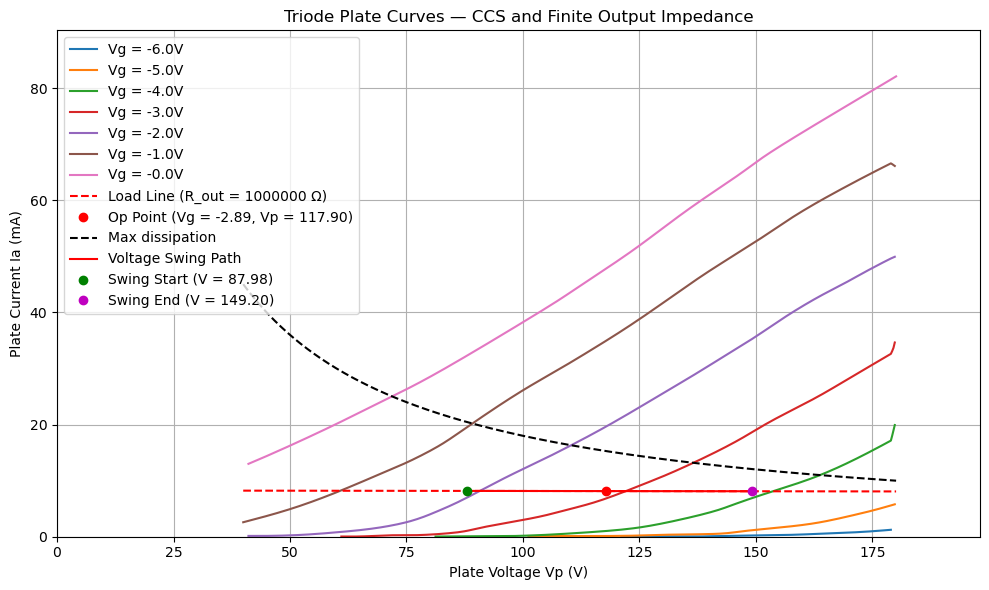

Animation saved as triode_ccs_voltage_swing.gif


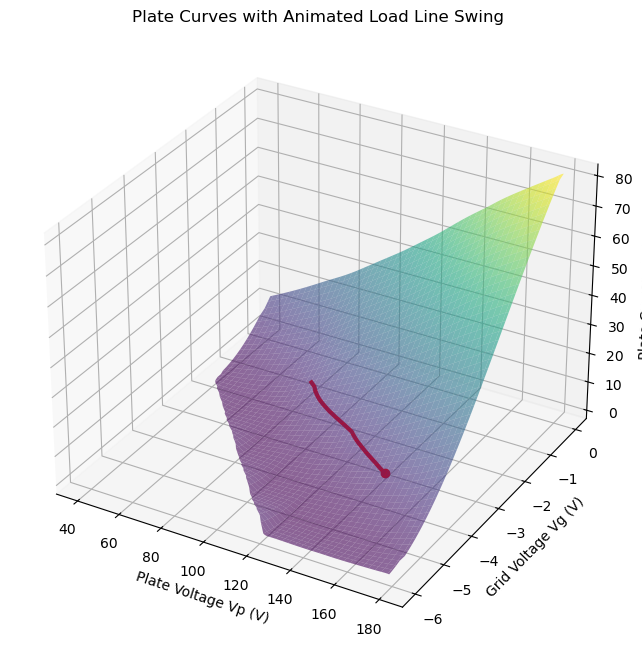

In [23]:
# Load CSV data
df = pd.read_csv("6922EH_plate_curves_2.csv")

# Flip grid voltages negative (fix)
df["Vg"] = -np.abs(df["Vg"])

Vp_data = df["Vp"].values
Vg_data = df["Vg"].values
Ia_data = df["Ia"].values

Vp_data = np.array(Vp_data)
Vg_data = np.array(Vg_data)
Ia_data = np.array(Ia_data)

triode3 = Triode(Vp_data, Ia_data, Vg_data, 1.8, 32, 13, 680) # Triode; Vp_data, Ia_data, Vg_data, dissipation, mu, gm, plate_resist
# triode3.plot_three_D_manifold()
# basic_circuit3 = Basic_Circuit(triode3, 175, 8000, 200, 10, 2) # Load line for plate_current in milliamps; triode, B_plus, anode_resist, cathode_resist, plate_current, pk_pk, debug = False
# basic_circuit3.plot_load_line()
ccs_circuit3 = CCS_Circuit(triode3, 240, 117.9, 8.14, 2) # CCS load line; triode, B_plus, plate_voltage, plate_current, pk_pk, output_impede = None, debug = False)
ccs_circuit3.plot_load_line()
# white_cathode3 = White_Cathode_Follower_Circuit(triode3, 600, 0.1, 240, 10, 13.96) # White Cathode Follower; triode, output_impede, hp_diss, B_plus, plate_current, pk_pk, debug = False
# white_cathode3.plot_load_line()
# triode3.optimize_operating_point()

## 6H30

Cathode Resistor: 365.0
Anode Resistor: 536.0
[11.2175444]
Gain = 0.981647


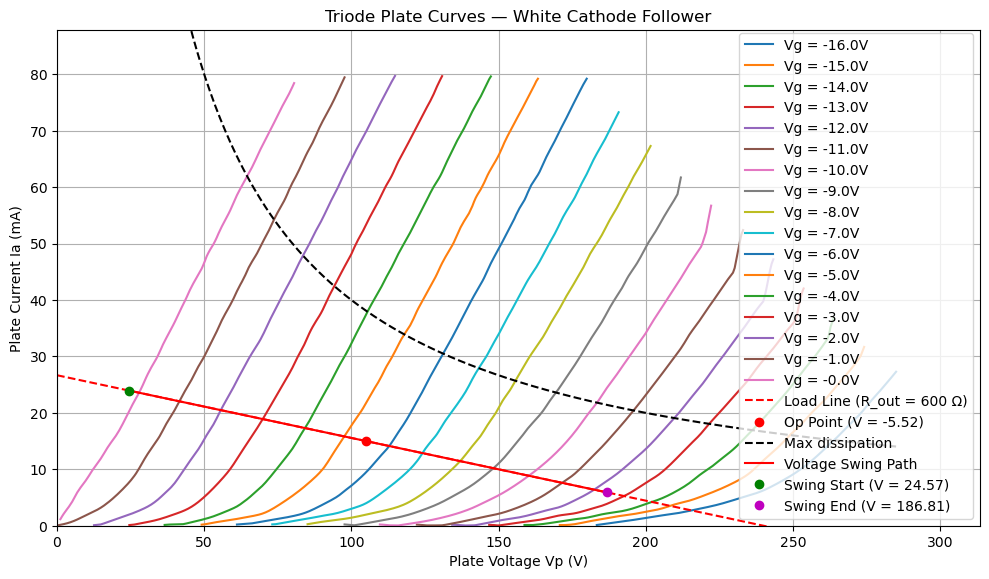

In [ ]:
# Load CSV data
df = pd.read_csv("sovtek-6h30pi_plate_curves_2.csv")

# Flip grid voltages negative (fix)
df["Vg"] = -np.abs(df["Vg"])

Vp_data = df["Vp"].values
Vg_data = df["Vg"].values
Ia_data = df["Ia"].values

Vp_data = np.array(Vp_data)
Vg_data = np.array(Vg_data)
Ia_data = np.array(Ia_data)

triode3 = Triode(Vp_data, Ia_data, Vg_data, 4.0, 15, 18, 840) # Triode; Vp_data, Ia_data, Vg_data, dissipation, mu, gm, plate_resist
# triode3.plot_three_D_manifold()
# basic_circuit3 = Basic_Circuit(triode3, 240, 6000, 499, 22, 22) # Load line for plate_current in milliamps; triode, B_plus, anode_resist, cathode_resist, plate_current, pk_pk, debug = False
# basic_circuit3.plot_load_line()
# ccs_circuit3 = CCS_Circuit(triode3, 240, 120, 10, 14, 600) # CCS load line; plate_voltage, plate_current, pk_pk, output_impede = None
# ccs_circuit3.plot_load_line()
white_cathode3 = White_Cathode_Follower_Circuit(triode3, 600, 0.1, 240, 15, 13.96) # White Cathode Follower; triode, output_impede, hp_diss, B_plus, plate_current, pk_pk, debug = False
white_cathode3.plot_load_line()
# triode3.optimize_operating_point()

## Main Pentode Class

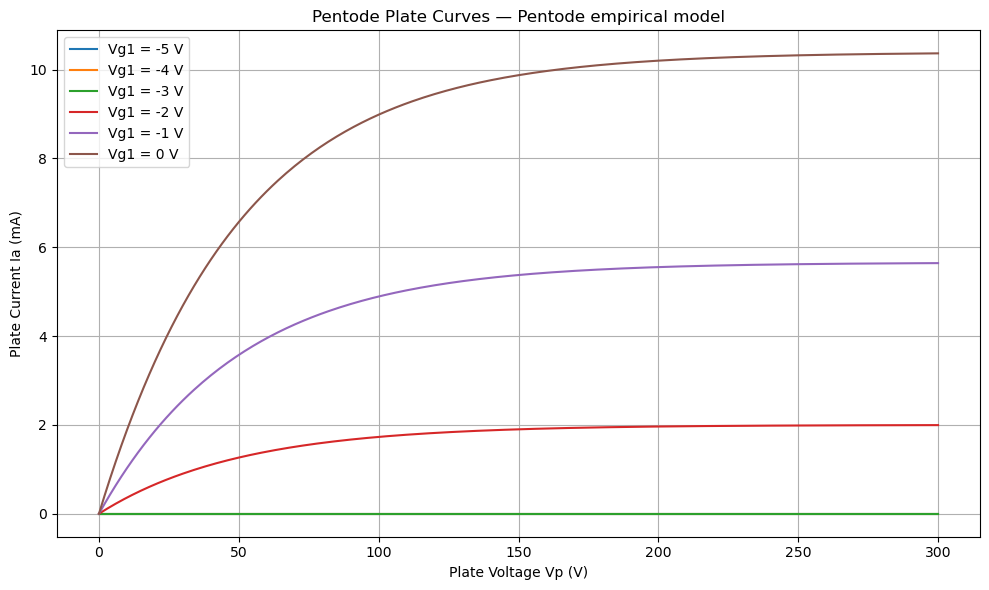

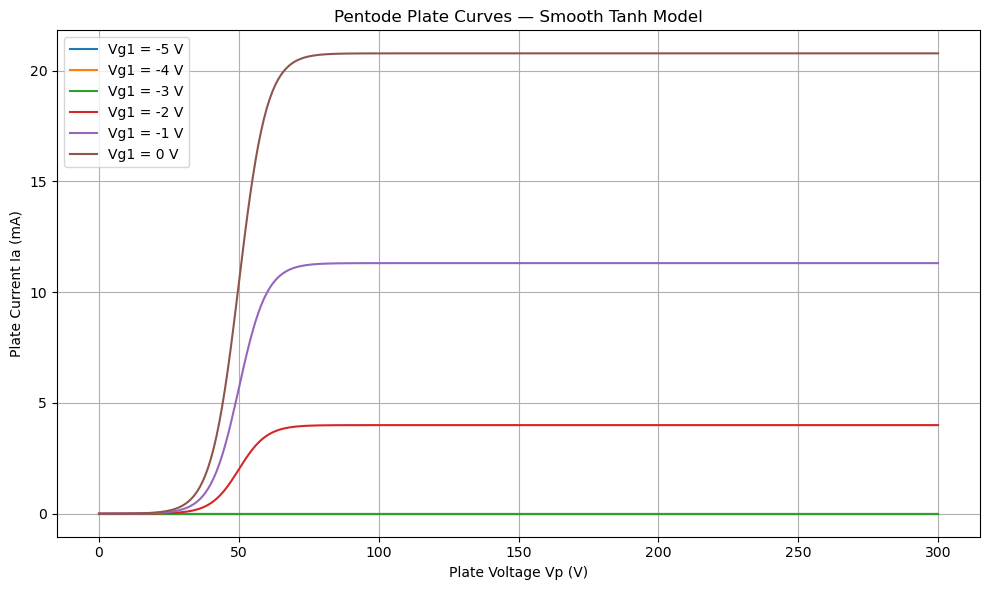

In [4]:
class CustomError(Exception):
    def __init__(self, message = "An error occurred", detail = None):
        super().__init__(message)
        self.detail = detail

    def __str__(self):
         return f"{super().__str__()} (Details: {self.detail})" if self.detail else super().__str__()

class Pentode:
    def __init__(self, Vp, Vg_list, Vg2,  I0, Vg2_0, Vcut, alpha, beta, Vsat = None, Vknee = None, Vslope = None):
        self.Ip = []
        for Vg1 in Vg_list:
            if Vsat and not (Vknee and Vslope):
                # Pentode empirical model
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                term1 = (Vg2 / Vg2_0) ** alpha
                term2 = Vg1_eff ** beta
                term3 = 1 - np.exp(-Vp / Vsat)
                self.Ip.append(I0 * term1 * term2 * term3)
            elif (Vknee and Vslope) and not Vsat:
                # Smoothed pentode model with tanh knee transition
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                I_sat = I0 * (Vg2 / Vg2_0)**alpha * Vg1_eff**beta
                transition = 1 - np.tanh((Vknee - Vp) / Vslope)
                self.Ip.append(I_sat * transition)
            else:
                optionals = {"Vsat": Vsat, "Vknee": Vknee, "Vslope": Vslope}
                [print(key) for key, value in optionals.items() if value is None]
                raise CustomError("Missing values", detail = "Missing either " + str([key for key, value in optionals.items() if value is None]))
                
Vg2 = 150
I0 = 2.0
Vg2_0 = 150
Vcut = -3.0
alpha = 1.0
beta = 1.5
Vsat = 50

# Voltage Sweep
Vp = np.linspace(0, 300, 301)
Vg1_list = [-5, -4, -3, -2, -1, 0]
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = Vsat)

# Plotting
plt.figure(figsize = (10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label = f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Pentode empirical model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Vknee = 50
Vslope = 10
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vknee = Vknee, Vslope = Vslope)

# Plotting
plt.figure(figsize = (10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label = f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Smooth Tanh Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()